# 📈 Week 3 Trading Strategy: Time Series Analysis

---

## 🎯 Strategy Overview

**Building on Week 1-2 + Adding Week 3 Concepts:**
- Foundation concepts (returns, volatility, correlation)
- Statistical analysis (distributions, hypothesis testing)
- **NEW:** Stationarity testing
- **NEW:** Autocorrelation analysis
- **NEW:** ARIMA forecasting
- **NEW:** GARCH volatility modeling

**Strategy Logic:**
1. Test stationarity of returns
2. Analyze autocorrelation for mean reversion
3. GARCH volatility forecasting for risk management
4. Volatility-adjusted position sizing

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3

print("=" * 60)
print("📊 WEEK 3 TRADING STRATEGY: TIME SERIES ANALYSIS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")

📊 WEEK 3 TRADING STRATEGY: TIME SERIES ANALYSIS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

try:
    from arch import arch_model
    ARCH_AVAILABLE = True
except ImportError:
    ARCH_AVAILABLE = False
    print("⚠️ arch package not installed. GARCH analysis will be skipped.")

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Stationarity Analysis (Week 3 Concept)

**Key Test: Augmented Dickey-Fuller (ADF)**
- Null hypothesis: Series has a unit root (non-stationary)
- p-value < 0.05: Reject null → Stationary

**Why this matters:**
Most time series models require stationarity. Prices are non-stationary; returns are typically stationary.

In [3]:
# ============================================================
# STATIONARITY TESTING
# ============================================================

def adf_test(series):
    """Perform ADF test."""
    result = adfuller(series.dropna())
    return {'adf_stat': result[0], 'p_value': result[1], 'stationary': result[1] < 0.05}

print("📊 STATIONARITY TESTS (ADF)")
print("=" * 70)
print(f"\n{'Series':<25} {'ADF Stat':>15} {'p-value':>15} {'Stationary?':>15}")
print("-" * 70)

stationarity_results = {}
for ticker in TICKERS:
    # Test prices
    price_result = adf_test(prices[ticker])
    print(f"{ticker} Prices{'':15} {price_result['adf_stat']:>15.4f} {price_result['p_value']:>15.4f} {'No ❌':>15}")
    
    # Test returns
    return_result = adf_test(returns[ticker])
    stationarity_results[ticker] = return_result
    status = "Yes ✅" if return_result['stationary'] else "No ❌"
    print(f"{ticker} Returns{'':14} {return_result['adf_stat']:>15.4f} {return_result['p_value']:>15.4f} {status:>15}")
    print()

print("📈 Key Insight: Prices are non-stationary, returns are stationary!")

📊 STATIONARITY TESTS (ADF)

Series                           ADF Stat         p-value     Stationary?
----------------------------------------------------------------------
AAPL Prices                        -1.6597          0.4520            No ❌
AAPL Returns                      -13.9976          0.0000           Yes ✅

MSFT Prices                        -2.1895          0.2101            No ❌
MSFT Returns                      -27.8446          0.0000           Yes ✅

GOOGL Prices                         1.2460          0.9963            No ❌
GOOGL Returns                      -16.6848          0.0000           Yes ✅

AMZN Prices                        -1.4963          0.5354            No ❌
AMZN Returns                      -21.4346          0.0000           Yes ✅

META Prices                        -1.7353          0.4130            No ❌
META Returns                      -28.2836          0.0000           Yes ✅

📈 Key Insight: Prices are non-stationary, returns are stationary!


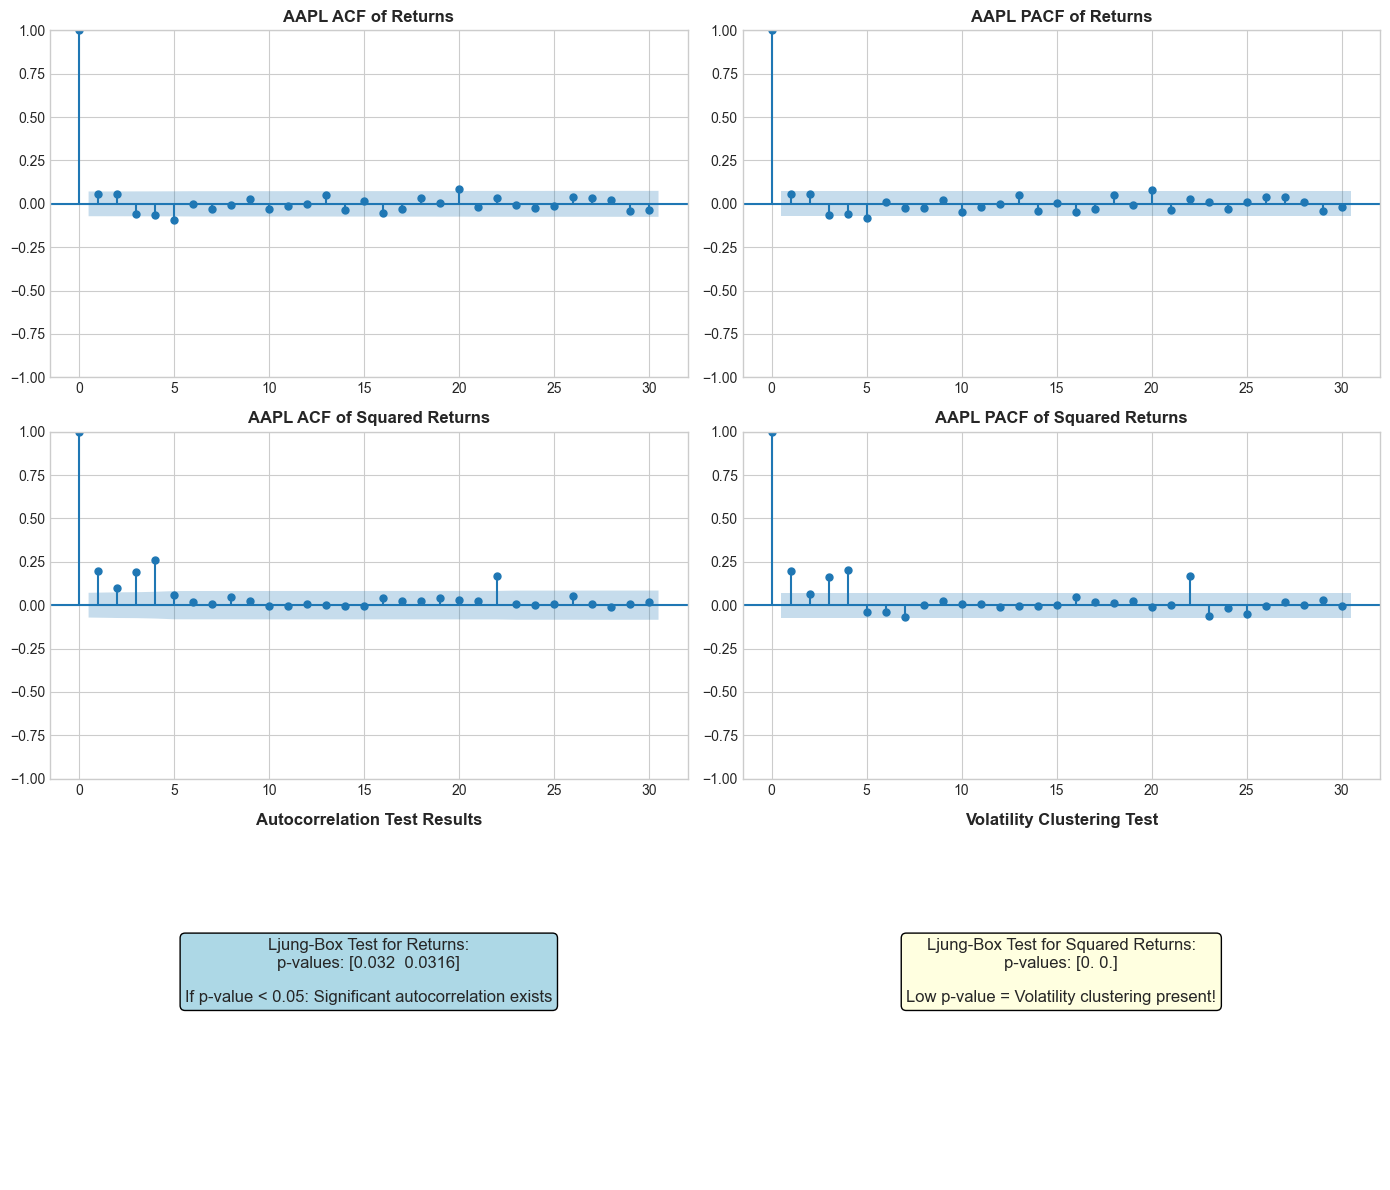


📈 Observations:
1. Returns show little autocorrelation (markets are efficient)
2. Squared returns show significant autocorrelation (volatility clusters!)


In [4]:
# ============================================================
# AUTOCORRELATION ANALYSIS
# ============================================================

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

ticker = TICKERS[0]
ret = returns[ticker]

# ACF of returns
plot_acf(ret, lags=30, ax=axes[0, 0])
axes[0, 0].set_title(f'{ticker} ACF of Returns', fontsize=12, fontweight='bold')

# PACF of returns
plot_pacf(ret, lags=30, ax=axes[0, 1])
axes[0, 1].set_title(f'{ticker} PACF of Returns', fontsize=12, fontweight='bold')

# ACF of squared returns (volatility clustering)
plot_acf(ret**2, lags=30, ax=axes[1, 0])
axes[1, 0].set_title(f'{ticker} ACF of Squared Returns', fontsize=12, fontweight='bold')

# PACF of squared returns
plot_pacf(ret**2, lags=30, ax=axes[1, 1])
axes[1, 1].set_title(f'{ticker} PACF of Squared Returns', fontsize=12, fontweight='bold')

# Ljung-Box test interpretation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_returns = acorr_ljungbox(ret, lags=[10, 20], return_df=True)
lb_squared = acorr_ljungbox(ret**2, lags=[10, 20], return_df=True)

axes[2, 0].text(0.5, 0.6, f"Ljung-Box Test for Returns:\np-values: {lb_returns['lb_pvalue'].values.round(4)}\n\n" +
                "If p-value < 0.05: Significant autocorrelation exists",
                ha='center', va='center', fontsize=12, transform=axes[2, 0].transAxes,
                bbox=dict(boxstyle='round', facecolor='lightblue'))
axes[2, 0].axis('off')
axes[2, 0].set_title('Autocorrelation Test Results', fontsize=12, fontweight='bold')

axes[2, 1].text(0.5, 0.6, f"Ljung-Box Test for Squared Returns:\np-values: {lb_squared['lb_pvalue'].values.round(4)}\n\n" +
                "Low p-value = Volatility clustering present!",
                ha='center', va='center', fontsize=12, transform=axes[2, 1].transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow'))
axes[2, 1].axis('off')
axes[2, 1].set_title('Volatility Clustering Test', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Observations:")
print("1. Returns show little autocorrelation (markets are efficient)")
print("2. Squared returns show significant autocorrelation (volatility clusters!)")

---

## 📊 Section 2: GARCH Volatility Modeling (Week 3 Concept)

**GARCH(1,1) Model:**
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

**Key Parameters:**
- α (alpha): Reaction to recent shocks
- β (beta): Volatility persistence
- α + β: Total persistence (close to 1 = slow mean reversion)

In [5]:
# ============================================================
# GARCH VOLATILITY MODELING
# ============================================================

garch_results = {}

if ARCH_AVAILABLE:
    print("📊 GARCH(1,1) VOLATILITY MODELING")
    print("=" * 80)
    print(f"\n{'Ticker':<10} {'α (ARCH)':>12} {'β (GARCH)':>12} {'Persistence':>12} {'Long-run Vol':>15}")
    print("-" * 80)
    
    for ticker in TICKERS:
        ret_pct = returns[ticker] * 100  # Scale for numerical stability
        
        try:
            model = arch_model(ret_pct, vol='Garch', p=1, q=1, mean='Constant')
            fit = model.fit(disp='off')
            
            alpha = fit.params['alpha[1]']
            beta = fit.params['beta[1]']
            omega = fit.params['omega']
            persistence = alpha + beta
            
            # Long-run volatility
            if persistence < 1:
                long_run_vol = np.sqrt(omega / (1 - alpha - beta)) * np.sqrt(252)
            else:
                long_run_vol = np.nan
            
            garch_results[ticker] = {
                'alpha': alpha, 'beta': beta, 'persistence': persistence,
                'long_run_vol': long_run_vol, 'fit': fit,
                'cond_vol': fit.conditional_volatility / 100 * np.sqrt(252)  # Annualized
            }
            
            print(f"{ticker:<10} {alpha:>12.4f} {beta:>12.4f} {persistence:>12.4f} {long_run_vol:>14.2f}%")
        
        except Exception as e:
            print(f"{ticker:<10} {'Failed':>12}")
    
    print("\n📈 Interpretation:")
    print("   - High persistence (>0.95): Volatility shocks are long-lasting")
    print("   - Use conditional volatility for dynamic position sizing")
else:
    print("⚠️ GARCH analysis skipped (arch package not installed)")

📊 GARCH(1,1) VOLATILITY MODELING

Ticker         α (ARCH)    β (GARCH)  Persistence    Long-run Vol
--------------------------------------------------------------------------------
AAPL             0.0721       0.8597       0.9318          24.46%
MSFT             0.0472       0.8865       0.9337          22.84%
GOOGL            0.0004       0.9508       0.9513          29.17%
AMZN             0.1838       0.5127       0.6965          32.33%
META             0.0004       0.9536       0.9540          35.36%

📈 Interpretation:
   - High persistence (>0.95): Volatility shocks are long-lasting
   - Use conditional volatility for dynamic position sizing


In [6]:
# ============================================================
# VOLATILITY-ADJUSTED TRADING STRATEGY
# ============================================================

def volatility_adjusted_strategy(prices, returns, vol_target=0.15):
    """
    Strategy that adjusts position size based on volatility.
    Lower volatility = larger position, higher volatility = smaller position.
    """
    # Rolling 20-day volatility
    rolling_vol = returns.rolling(20).std() * np.sqrt(252)
    
    # Position size (inversely proportional to vol, capped at 2x)
    position_size = np.minimum(vol_target / rolling_vol, 2.0)
    position_size = position_size.fillna(1.0)
    
    # Strategy returns
    strategy_returns = returns * position_size.shift(1)
    
    return {
        'position_size': position_size,
        'strategy_returns': strategy_returns,
        'strategy_cum': (1 + strategy_returns).cumprod(),
        'buy_hold_cum': (1 + returns).cumprod()
    }

# Apply to all tickers
vol_strategy = {}
for ticker in TICKERS:
    vol_strategy[ticker] = volatility_adjusted_strategy(prices[ticker], returns[ticker])

print("📊 VOLATILITY-ADJUSTED STRATEGY RESULTS")
print("=" * 70)
print(f"\n{'Ticker':<10} {'Buy & Hold':>15} {'Vol-Adj Strategy':>18} {'Improvement':>15}")
print("-" * 70)

for ticker in TICKERS:
    bh_ret = vol_strategy[ticker]['buy_hold_cum'].iloc[-1] - 1
    strat_ret = vol_strategy[ticker]['strategy_cum'].iloc[-1] - 1
    improvement = strat_ret - bh_ret
    print(f"{ticker:<10} {bh_ret:>14.2%} {strat_ret:>17.2%} {improvement:>14.2%}")

📊 VOLATILITY-ADJUSTED STRATEGY RESULTS

Ticker          Buy & Hold   Vol-Adj Strategy     Improvement
----------------------------------------------------------------------
AAPL               86.13%            41.45%        -44.69%
MSFT              105.70%            66.80%        -38.90%
GOOGL             255.09%           106.05%       -149.03%
AMZN              155.29%            57.55%        -97.75%
META              387.23%           147.95%       -239.27%


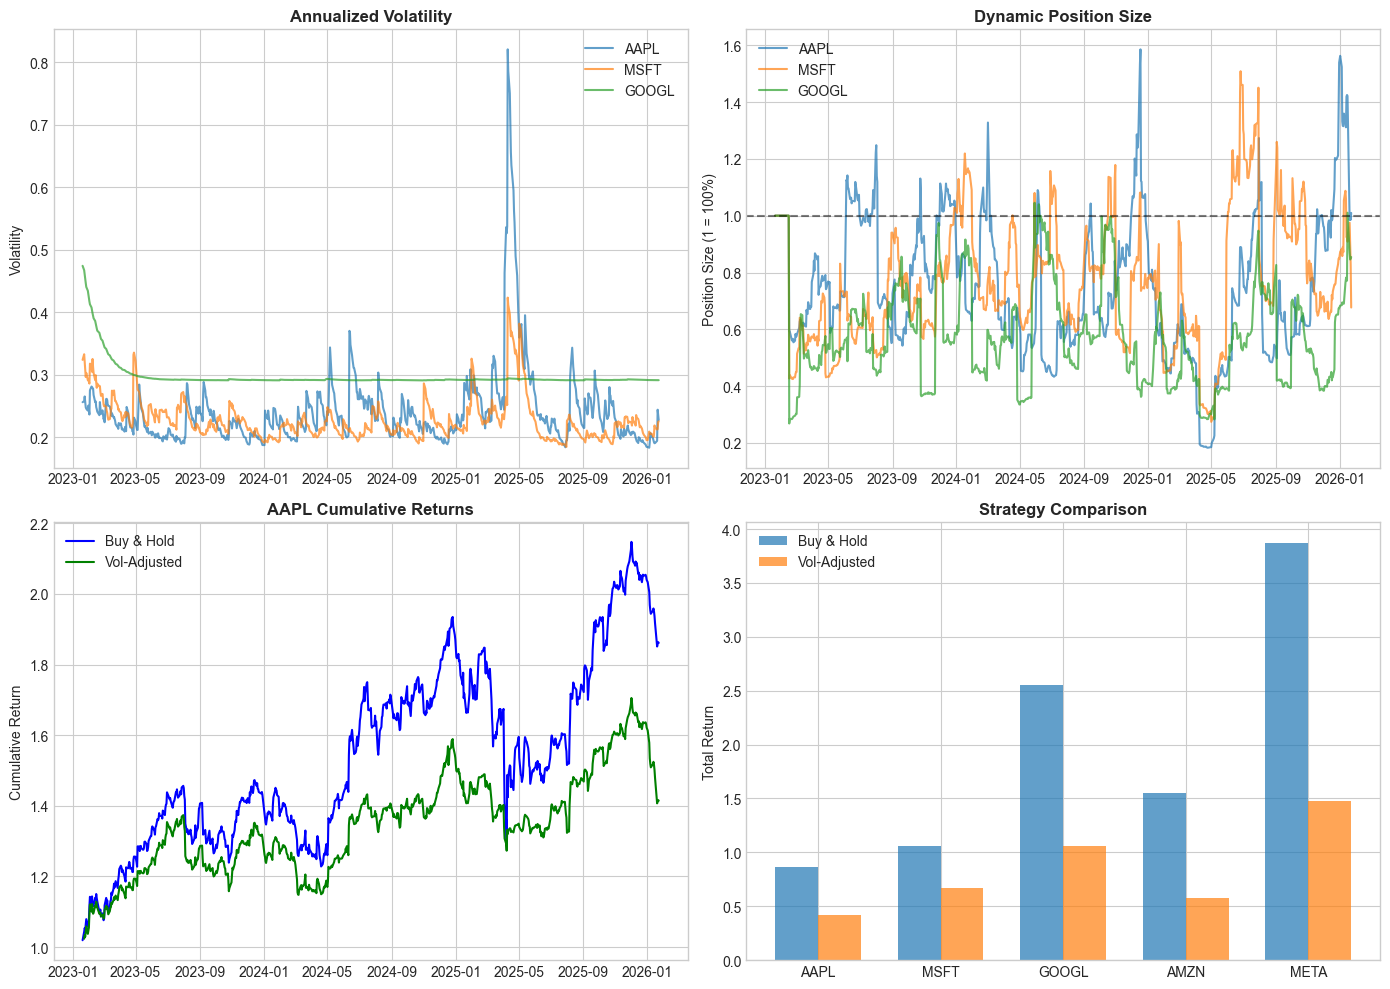

In [7]:
# ============================================================
# VISUALIZATION: Volatility Strategy
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Conditional Volatility (if GARCH available)
ax1 = axes[0, 0]
for ticker in TICKERS[:3]:
    if ARCH_AVAILABLE and ticker in garch_results:
        ax1.plot(garch_results[ticker]['cond_vol'], label=ticker, alpha=0.7)
    else:
        rolling_vol = returns[ticker].rolling(20).std() * np.sqrt(252)
        ax1.plot(rolling_vol, label=ticker, alpha=0.7)

ax1.set_title('Annualized Volatility', fontsize=12, fontweight='bold')
ax1.set_ylabel('Volatility')
ax1.legend()

# 2. Position Size Over Time
ax2 = axes[0, 1]
for ticker in TICKERS[:3]:
    ax2.plot(vol_strategy[ticker]['position_size'], label=ticker, alpha=0.7)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax2.set_title('Dynamic Position Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Position Size (1 = 100%)')
ax2.legend()

# 3. Cumulative Returns Comparison
ax3 = axes[1, 0]
ticker = TICKERS[0]
ax3.plot(vol_strategy[ticker]['buy_hold_cum'], 'b-', label='Buy & Hold')
ax3.plot(vol_strategy[ticker]['strategy_cum'], 'g-', label='Vol-Adjusted')
ax3.set_title(f'{ticker} Cumulative Returns', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Return')
ax3.legend()

# 4. Strategy Comparison Summary
ax4 = axes[1, 1]
bh_rets = [vol_strategy[t]['buy_hold_cum'].iloc[-1] - 1 for t in TICKERS]
strat_rets = [vol_strategy[t]['strategy_cum'].iloc[-1] - 1 for t in TICKERS]
x = np.arange(len(TICKERS))
width = 0.35
ax4.bar(x - width/2, bh_rets, width, label='Buy & Hold', alpha=0.7)
ax4.bar(x + width/2, strat_rets, width, label='Vol-Adjusted', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels(TICKERS)
ax4.set_title('Strategy Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Return')
ax4.legend()

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# FINAL ANALYSIS & RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 3 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Create summary
summary = pd.DataFrame(index=TICKERS)
summary['Stationary'] = [stationarity_results[t]['stationary'] for t in TICKERS]
summary['Current Vol'] = [returns[t].rolling(20).std().iloc[-1] * np.sqrt(252) for t in TICKERS]

if ARCH_AVAILABLE:
    summary['GARCH Vol'] = [garch_results[t]['cond_vol'].iloc[-1] if t in garch_results else np.nan for t in TICKERS]
    summary['Persistence'] = [garch_results[t]['persistence'] if t in garch_results else np.nan for t in TICKERS]

summary['Position Size'] = [vol_strategy[t]['position_size'].iloc[-1] for t in TICKERS]
summary['Strategy Return'] = [vol_strategy[t]['strategy_cum'].iloc[-1] - 1 for t in TICKERS]

print("\n📋 STOCK ANALYSIS:")
print(summary.round(4).to_string())

# Recommendations
print("\n🏆 RECOMMENDATIONS:")

# Low volatility (can take larger position)
low_vol_ticker = summary['Current Vol'].idxmin()
print(f"1. 🛡️ LOWEST VOLATILITY: {low_vol_ticker} ({summary.loc[low_vol_ticker, 'Current Vol']:.2%} annual)")
print(f"   → Suggested position size: {summary.loc[low_vol_ticker, 'Position Size']:.1%}")

# High volatility (reduce position)
high_vol_ticker = summary['Current Vol'].idxmax()
print(f"\n2. ⚠️ HIGHEST VOLATILITY: {high_vol_ticker} ({summary.loc[high_vol_ticker, 'Current Vol']:.2%} annual)")
print(f"   → Suggested position size: {summary.loc[high_vol_ticker, 'Position Size']:.1%}")

# Best strategy performance
best_strat = summary['Strategy Return'].idxmax()
print(f"\n3. 🏆 BEST VOL-ADJUSTED PERFORMANCE: {best_strat} ({summary.loc[best_strat, 'Strategy Return']:.2%})")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 3 STRATEGY - FINAL RECOMMENDATIONS

📋 STOCK ANALYSIS:
       Stationary  Current Vol  GARCH Vol  Persistence  Position Size  Strategy Return
AAPL         True       0.1486     0.2275       0.9318         1.0096           0.4145
MSFT         True       0.2216     0.2254       0.9337         0.6769           0.6680
GOOGL        True       0.1756     0.2913       0.9513         0.8544           1.0605
AMZN         True       0.2681     0.2970       0.6965         0.5596           0.5755
META         True       0.3002     0.3532       0.9540         0.4997           1.4795

🏆 RECOMMENDATIONS:
1. 🛡️ LOWEST VOLATILITY: AAPL (14.86% annual)
   → Suggested position size: 101.0%

2. ⚠️ HIGHEST VOLATILITY: META (30.02% annual)
   → Suggested position size: 50.0%

3. 🏆 BEST VOL-ADJUSTED PERFORMANCE: META (147.95%)

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-3)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Base metrics |
| 2 | Statistical Testing | Significance analysis |
| **3** | **Stationarity (ADF)** | **Validate modeling assumptions** |
| **3** | **Autocorrelation (ACF/PACF)** | **Pattern identification** |
| **3** | **GARCH** | **Volatility forecasting** |
| **3** | **Position Sizing** | **Risk management** |

---